# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

/home/willem/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

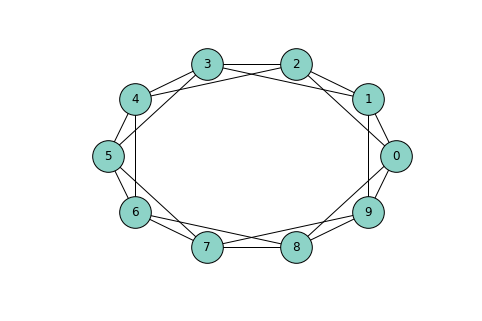

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=2` or `k=5`.

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

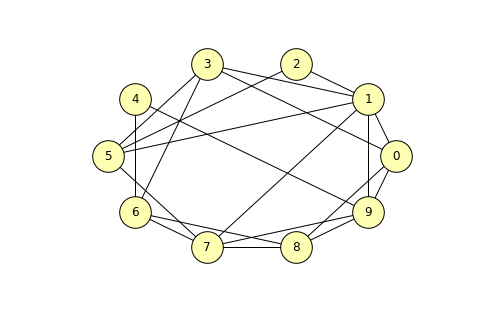

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

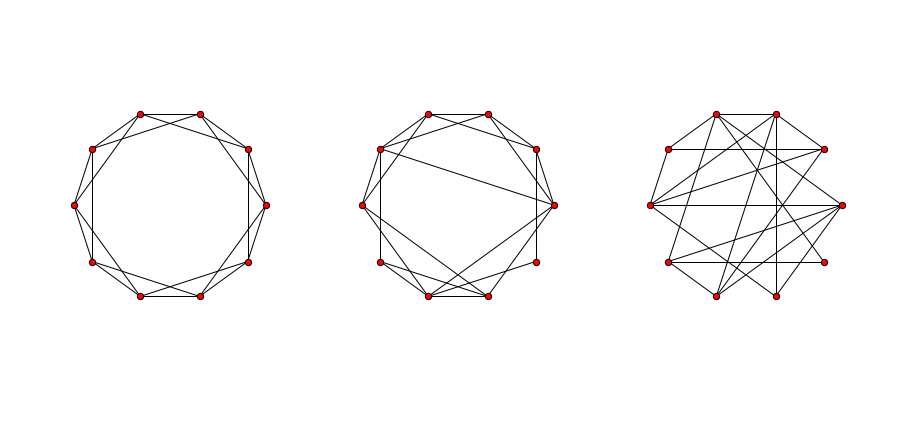

In [12]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

In [13]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes()) #constant time?
    for edge in G.edges(): #O(len(G.edges)) O(m) for loop
        if flip(p): #constant time...
            u, v = edge #constant
            choices = nodes - {u} - set(G[u]) #n
            new_v = choice(tuple(choices)) #n
            G.remove_edge(u, v)  #dictionary deletions, constant time
            G.add_edge(u, new_v)

#order of growth... looks like O(mn), m being order of growth of the foor loop and n 
#being order of growth of the contents of the for loop

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [14]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    exist = len([v for v, w in all_pairs(neighbors) if G.has_edge(v,w) ])
#     for v, w in all_pairs(neighbors):
#         if G.has_edge(v, w):
#             exist +=1
    return exist / total



def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [15]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [16]:
lattice = make_ring_lattice(16, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [17]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [18]:

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    
    # O(k) dict
    neighbors = G[u]
    
    
    k = len(neighbors)
    if k < 2:
        return 0
        
    #O(1)    
    total = k * (k-1) / 2
    exist = 0    
    
    #list comp (all_pairs is in O(k^2) because of its nested for loop)
    
    exist = len([v for v, w in all_pairs(neighbors) if G.has_edge(v,w)])
    return exist / total

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [19]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    
    """
    
    #np.mean in O(n), node_cluster in O(k^2), list comp in O(n)
    cc = np.mean([node_clustering(G, node) for node in G])
    #node_clustering in O(m), list comp in O(n)
    return cc

#order of growth in O(n*(k^2))
#this was very confusing for me

## Path length

The following function computes path lengths between all pairs of nodes

In [20]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [21]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

On a complete graph, the average path length should be 1

In [22]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [23]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [24]:
lattice_2 = make_ring_lattice(10, 4)
characteristic_path_length(lattice_2)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [25]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [26]:
%time run_one_graph(1000, 10, 0.01)

8.28896696697 0.644773015873
CPU times: user 1.24 s, sys: 52 ms, total: 1.29 s
Wall time: 1.27 s


(8.2889669669669672, 0.64477301587301572)

Now we'll run it with a range of values for `p`.

In [27]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [28]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [29]:
res = run_experiment(ps)

0.0001
40.5586446446 0.666423232323
50.4504504505 0.666666666667
50.4504504505 0.666666666667
42.5435135135 0.666423232323
50.4504504505 0.666666666667
47.2872632633 0.666278787879
50.4504504505 0.666666666667
49.82804004 0.666351010101
40.1102762763 0.666134343434
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
39.6356356356 0.665963131313
37.9293013013 0.666107575758
50.4211191191 0.666384848485
50.4504504505 0.666666666667
39.8014494494 0.666351010101
50.4504504505 0.666666666667
50.4504504505 0.666666666667
0.000316227766017
38.53002002 0.666423232323
32.7859219219 0.665286363636
36.9473093093 0.665890909091
26.7532292292 0.665503030303
36.4936216216 0.665746464646
34.7754554555 0.665746464646
41.8450750751 0.666278787879
45.4095435435 0.665963131313
33.5735475475 0.665963131313
38.6045785786 0.666423232323
32.2358298298 0.665042929293
33.3399079079 0.665746464646
38.742980981 0.666278787879
45.4724864865 0.6661343

Now we have to extract them in a form we can plot

In [30]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[47.153509909909921, 38.388214414414421, 27.601071771771775, 16.023970970970971, 8.8731543543543534, 5.9947393393393389, 4.436626826826827, 3.5785572572572568, 3.2671586586586585]
[0.66648752525252497, 0.66589131313131311, 0.6647615909090907, 0.66104016594516579, 0.64724840548340556, 0.60793369602619596, 0.49004759712509716, 0.21974964924781104, 0.0093260291789393941]


And normalize them so they both start at 1.0

In [31]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

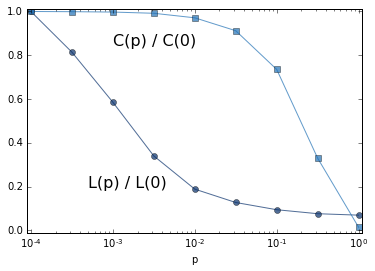

In [32]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [33]:
lattice = make_ring_lattice(10, 4)

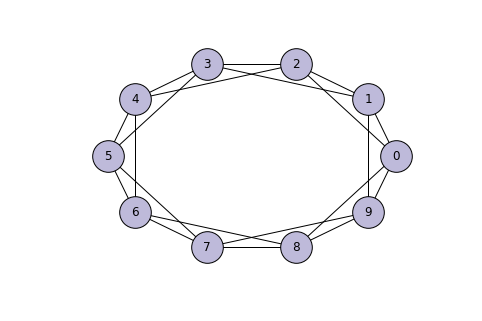

In [34]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [35]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [36]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [37]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [38]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [39]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [40]:
lattice = make_ring_lattice(10, 4)

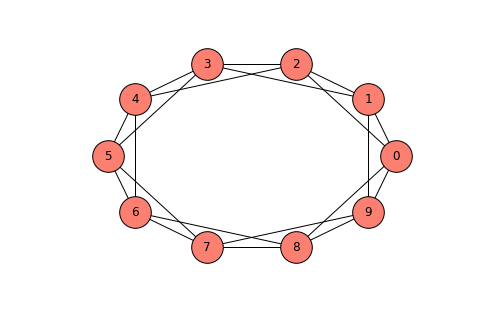

In [41]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [42]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [43]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [44]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [45]:
"""shortest path length = 1000/5 because if each nodes has a degree of 10, that means that hopping from one node
to its next farthest reachable node results in a distance gain of 5 nodes

^whoops looks like there was a lapse in my logic, the farthest point from node 0 would be 500 nodes away, not 
1000 like i thought above"""

lattice_1k = make_ring_lattice(1000, 10)
d3 = shortest_path_dijkstra(lattice_1k, 0)
d3

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 3,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 26: 6,
 27: 6,
 28: 6,
 29: 6,
 30: 6,
 31: 7,
 32: 7,
 33: 7,
 34: 7,
 35: 7,
 36: 8,
 37: 8,
 38: 8,
 39: 8,
 40: 8,
 41: 9,
 42: 9,
 43: 9,
 44: 9,
 45: 9,
 46: 10,
 47: 10,
 48: 10,
 49: 10,
 50: 10,
 51: 11,
 52: 11,
 53: 11,
 54: 11,
 55: 11,
 56: 12,
 57: 12,
 58: 12,
 59: 12,
 60: 12,
 61: 13,
 62: 13,
 63: 13,
 64: 13,
 65: 13,
 66: 14,
 67: 14,
 68: 14,
 69: 14,
 70: 14,
 71: 15,
 72: 15,
 73: 15,
 74: 15,
 75: 15,
 76: 16,
 77: 16,
 78: 16,
 79: 16,
 80: 16,
 81: 17,
 82: 17,
 83: 17,
 84: 17,
 85: 17,
 86: 18,
 87: 18,
 88: 18,
 89: 18,
 90: 18,
 91: 19,
 92: 19,
 93: 19,
 94: 19,
 95: 19,
 96: 20,
 97: 20,
 98: 20,
 99: 20,
 100: 20,
 101: 21,
 102: 21,
 103: 21,
 104: 21,
 105: 21,
 106: 22,
 107: 22,
 108: 22,
 109: 22,
 110: 22,
 111: 23,
 112: 23,
 113: 23,
 114: 23,
 115: 

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

{8: {}, 0: {}, 2: {}, 3: {}, 13: {}}


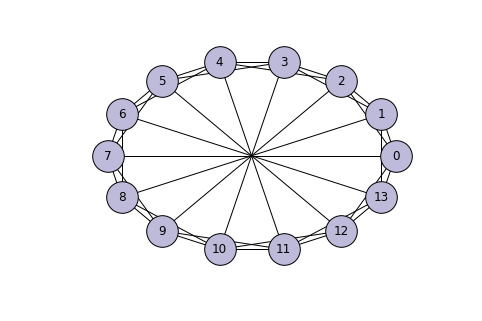

In [46]:
def make_regular_graph(n, k):
    """Makes a regular graph with `n` nodes and degree `k`.
    
    Note: will not work if n*k is odd
    
    n: number of nodes
    k: degree of each node
    """
    if n*k%2 != 0:
        raise ValueError('n*k needs to be even')
    
            
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
   
    
  
    if k%2 != 0:
        
        nodes_first_half = nodes[0:int(len(nodes)/2)]
        #nodes_second_half_reverse = nodes[int(len(nodes)/2):][::-1] lol jk this doesnt work
      
        
        halfway_point = int(len(nodes)/2)
        
        #connects each node to the node directly across from it
        edges = [(nodes[i], nodes[i+halfway_point]) for i in range(halfway_point)]
        
        G.add_edges_from(edges)
        
        #subtract one degree and create the additional egdes using the latice graph method
        k = k-1 
        G.add_edges_from(adjacent_edges(nodes, (k)//2))
        
    else:
        G.add_edges_from(adjacent_edges(nodes, k//2))
        
    print(G[1])
    
    return G


reg_graph = make_regular_graph(14,5)

nx.draw_circular(reg_graph, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

In [47]:
# Solution goes here

In [48]:
# Solution goes here

In [49]:
# Solution goes here

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [50]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    
    
    seen = set() #constant time
    
    nextlevel = {source} #constant time?
    while nextlevel:
        thislevel = nextlevel #constant time
        nextlevel = set() #constant time
        for v in thislevel: #O(k)
            if v not in seen: #O(n)
                seen.add(v) #constant
                nextlevel.update(G[v]) #constant
    return seen

#this function appears to be in O(nk) which would make it slower than reach_nodes_bfs...


Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [51]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    
    
    
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft() #constant
        new_dist = dist[node] + 1 #constant

        neighbors = set(G[node]) - set(dist)  #O(k)
        for n in neighbors: #O(k)
            dist[n] = new_dist #constant?
        
        queue.extend(neighbors) #O(k)
        
    return dist


In [52]:
# Solution goes here

In [53]:
# Solution goes here

In [54]:
# Solution goes here

In [55]:
# Solution goes here

In [56]:
# Solution goes here

In [57]:
# Solution goes here

In [58]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [59]:
#this uses a list instead of a deque...
#and is not poping left, which is what would making it a breadth first search
#it also checks the dequeue in the list comprehension when
#only checking 'visited' should suffice

def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)
        
#actual order of growth in O(n^2) because it cycles through the while loop n 
#times, but the popping is in O(n)


In [60]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = deque([start])
    while len(queue):
        curr_node = queue.popleft(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited)

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

Exercise 3.5:

In [74]:
G = nx.barbell_graph(50,30)

p_vals = [m/10.0 for m in range(10)]

print('path length: ' + str(characteristic_path_length(G)))
print('clustering coefficient: ' + str(clustering_coefficient(G)))

for p in p_vals:
    G = nx.barbell_graph(10,10)
    print('p_val: ' + str(p))
    rewire(G, p)
    print('path length: ' + str(characteristic_path_length(G)))
    print('clustering coefficient: ' + str(clustering_coefficient(G)))
    print('')




#at around p = .3 and p = .4 we get a cluster coefficient that is close to what we might  
#look for in a small world graph, whereas the initial graph, before rewiring, has to high an
#average path length and two high a cluster coefficient

path length: 16.5515802027
clustering coefficient: 0.768615384615
p_val: 0.0
path length: 6.47126436782
clustering coefficient: 0.653333333333

p_val: 0.1
path length: 2.50114942529
clustering coefficient: 0.523439153439

p_val: 0.2
path length: 2.19770114943
clustering coefficient: 0.386560846561

p_val: 0.3
path length: 2.14252873563
clustering coefficient: 0.362592592593

p_val: 0.4
path length: 2.02528735632
clustering coefficient: 0.275630850631

p_val: 0.5
path length: 1.9724137931
clustering coefficient: 0.238075998076

p_val: 0.6
path length: 1.98850574713
clustering coefficient: 0.304881969882

p_val: 0.7
path length: 1.96551724138
clustering coefficient: 0.27145965146

p_val: 0.8
path length: 1.93563218391
clustering coefficient: 0.348304726463

p_val: 0.9
path length: 1.91494252874
clustering coefficient: 0.289257224257

